In [ ]:
%load_ext autoreload
%autoreload 2
import time
import multiprocessing
import os
from pathlib import Path
import shutil
import numpy as np
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.option as option
import thor.track as track
import thor.analyze as analyze
import thor.parallel as parallel
import thor.visualize as visualize
import thor.log as log

notebook_name = "gridrad_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Parent directory for saving outputs
base_local = Path.home() / "THOR_output"
year=2010
event_directories = data.gridrad.get_event_directories(year, base_local=base_local)
event_directory = event_directories[0]
start, end, event_start = data.gridrad.get_event_times(event_directory)
start = "2010-03-11T01:00:00"
end = "2010-03-11T02:00:00"

period = parallel.get_period(start, end)
intervals = parallel.get_time_intervals(start, end, period=period)

output_parent = base_local / f"runs/gridrad_demo_{event_start.replace('-', '')}"
event_start

'2010-01-20'

In [4]:
if output_parent.exists():
    shutil.rmtree(output_parent)
options_directory = output_parent / "options"

# Create the data_options dictionary
converted_options = {"save": True, "load": False, "parent_converted": None}
gridrad_options = data.gridrad.gridrad_data_options(
    start=start, end=end, converted_options=converted_options, event_start=event_start
)
lon_range = [-102, -89]
lat_range = [27, 39]
era5_pl_options = data.era5.data_options(
    start=start, end=end, longitude_range=lon_range, latitude_range=lat_range
)
args_dict = {"start": start, "end": end, "data_format": "single-levels"}
args_dict.update({"longitude_range": lon_range, "latitude_range": lat_range})
era5_sl_options = data.era5.data_options(**args_dict)

data_options = option.consolidate_options(
    [gridrad_options, era5_pl_options, era5_sl_options]
)
# for testing, ignore the era5 data
data_options = option.consolidate_options([gridrad_options])

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, options_directory=options_directory)
gridrad_options = data_options["gridrad"]

# Create the grid_options dictionary using the first file in the cpol dataset
grid_options = grid.create_options(
    name="geographic", regrid=False, altitude_spacing=None, geographic_spacing=None
)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, options_directory=options_directory)

# Create the track_options dictionary
track_options = option.default_track_options(dataset="gridrad")
# Modify the default options for gridrad. Because grids so large we now use a distinct
# global flow box for each object.
track_options.levels[1].objects[0].tracking.global_flow_margin = 70
track_options.levels[1].objects[0].tracking.unique_global_flow = False
# If testing, remove the profile and tag attributes
track_options.levels[1].objects[0].attributes["mcs"].pop("profile")
track_options.levels[1].objects[0].attributes["mcs"].pop("tag")
track_options.to_yaml(options_directory / "track.yml")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(obj, save=True, style="presentation")
    for obj in ["mcs"]
}
# visualize_options = None

2024-10-23 22:39:41,096 - thor.grid - WARNING - Shape not specified. Will attempt to infer from input.


In [5]:
%load_ext memory_profiler

In [15]:
times = data.utils.generate_times(data_options["gridrad"])
args = [times, data_options.copy(), grid_options.copy()]
args += [track_options.model_copy(), visualize_options]
track.simultaneous_track(*args, output_directory=output_parent)

2024-10-23 19:24:05,051 - thor.track - INFO - Beginning thor run. Saving output to /home/ewan/THOR_output/runs/gridrad_demo_20100310.
2024-10-23 19:24:05,054 - thor.track - INFO - Beginning simultaneous tracking.
2024-10-23 19:24:05,097 - thor.track - INFO - Processing 2010-03-10T16:00:00.
2024-10-23 19:24:05,099 - thor.data.gridrad - INFO - Updating gridrad dataset for 2010-03-10T16:00:00.
2024-10-23 19:24:05,100 - thor.data.gridrad - INFO - Converting gridrad data from nexrad_3d_v4_2_20100310T160000Z.nc
2024-10-23 19:24:06,454 - thor.track - INFO - Processing hierarchy level 0.
2024-10-23 19:24:06,455 - thor.track - INFO - Tracking convective.
2024-10-23 19:24:07,124 - thor.track - INFO - Tracking middle.
2024-10-23 19:24:07,225 - thor.track - INFO - Tracking anvil.
2024-10-23 19:24:07,343 - thor.track - INFO - Processing hierarchy level 1.
2024-10-23 19:24:07,344 - thor.track - INFO - Tracking mcs.
2024-10-23 19:24:07,546 - thor.match.match - INFO - Matching mcs objects.
2024-10-23 

In [ ]:
# num_processes = int(0.75 * os.cpu_count())
# num_processes = os.cpu_count()
num_processes = 6
kwargs = {"initializer": parallel.initialize_process, "processes": num_processes}
with log.logging_listener(), multiprocessing.get_context("spawn").Pool(**kwargs) as pool:
    results = []
    for i, time_interval in enumerate(intervals):
        time.sleep(1)
        args = [i, time_interval, data_options.copy(), grid_options.copy()]
        args += [track_options.model_copy(), visualize_options]
        args += [output_parent, "gridrad"]
        args = tuple(args)
        results.append(pool.apply_async(parallel.track_interval, args))
    pool.close()
    pool.join()
    parallel.check_results(results)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

2024-10-23 22:40:04,091 - thor.track - INFO - Beginning thor run. Saving output to /home/ewan/THOR_output/runs/gridrad_demo_20100120/interval_0.
2024-10-23 22:40:04,116 - thor.track - INFO - Beginning simultaneous tracking.
2024-10-23 22:40:04,201 - thor.track - INFO - Beginning thor run. Saving output to /home/ewan/THOR_output/runs/gridrad_demo_20100120/interval_1.
2024-10-23 22:40:04,202 - thor.track - INFO - Beginning simultaneous tracking.
2024-10-23 22:40:04,217 - thor.track - INFO - Processing 2010-01-20T18:00:00.
2024-10-23 22:40:04,218 - thor.data.gridrad - INFO - Updating gridrad dataset for 2010-01-20T18:00:00.
2024-10-23 22:40:04,218 - thor.data.gridrad - INFO - Converting gridrad data from nexrad_3d_v4_2_20100120T180000Z.nc
2024-10-23 22:40:04,278 - thor.track - INFO - Beginning thor run. Saving output to /home/ewan/THOR_output/runs/gridrad_demo_20100120/interval_2.
2024-10-23 22:40:04,278 - thor.track - INFO - Beginning simultaneous tracking.
2024-10-23 22:40:04,322 - thor

In [12]:
parallel.stitch_run(output_parent, intervals, cleanup=False)

2024-10-21 17:59:13,866 - thor.parallel - INFO - Stitching all attribute, mask and record files.


2024-10-21 17:59:16,448 - thor.parallel - INFO - Stitching record files.
2024-10-21 17:59:16,477 - thor.parallel - INFO - Stitching attribute files.
2024-10-21 17:59:16,958 - thor.parallel - INFO - Stitching mask files.


In [16]:
analysis_options = analyze.mcs.analysis_options()
analyze.mcs.process_velocities(output_parent, profile_dataset=None)
analyze.mcs.quality_control(output_parent, analysis_options)
# analyze.mcs.classify_all(output_parent)

convective_contained  anvil_contained  \
time                universal_id                                          
2010-03-10 16:00:00 1                             True             True   
                    2                            False            False   
2010-03-10 16:10:00 1                             True             True   
                    2                            False            False   
2010-03-10 16:20:00 1                             True             True   
...                                                ...              ...   
2010-03-11 09:00:00 51                           False            False   
2010-03-11 09:10:00 34                           False            False   
                    51                           False            False   
2010-03-11 09:20:00 34                           False            False   
                    51                           False            False   

                                  velocity  area  offset  major_axis  \
time                universal_id                                       
2010-03-10 16:00:00 1                 True  True    True        True   
                    2                 True  True    True        True   
2010-03-10 16:10:00 1                 True  True    True        True   
                    2                 True  True   False        True   
2010-03-10 16:20:00 1                 True  True    True        True   
...                                    ...   ...     ...         ...   
2010-03-11 09:00:00 51                True  True    True        True   
2010-03-11 09:10:00 34                True  True    True        True   
                    51                True  True    True        True   
2010-03-11 09:20:00 34                True  True    True        True   
                    51                True  True    True        True   

                                  axis_ratio  duration  
time                universal_id                        
2010-03-10 16:00:00 1                   True      True  
                    2                  False      True  
2010-03-10 16:10:00 1                   True      True  
                    2                  False      True  
2010-03-10 16:20:00 1                   True      True  
...                                      ...       ...  
2010-03-11 09:00:00 51                 False     False  
2010-03-11 09:10:00 34                  True      True  
                    51                 False     False  
2010-03-11 09:20:00 34                  True      True  
                    51                 False     False  

[431 rows x 8 columns]

In [ ]:
figure_options = visualize.option.horizontal_attribute_options(
    "mcs_velocity_analysis", style="presentation", attributes=["velocity", "offset"]
)
start_time = np.datetime64(start)
end_time = np.datetime64(end)
args = [output_parent, start_time, end_time, figure_options]
args_dict = {"parallel_figure": False, "dt": 7200, "by_date": False, "num_processes": 4}
visualize.attribute.mcs_series(*args, **args_dict)

2024-10-23 22:34:40,451 - thor.visualize.attribute - INFO - Visualizing MCS at time 2010-01-21T12:00:00.000000000.
2024-10-23 22:35:00,565 - thor.visualize.attribute - INFO - Saving mcs_velocity_analysis figure for 2010-01-21T12:00:00.000000000.
2024-10-23 22:35:09,302 - thor.visualize.attribute - INFO - Visualizing MCS at time 2010-01-21T12:10:00.000000000.
2024-10-23 22:35:32,948 - thor.visualize.attribute - INFO - Saving mcs_velocity_analysis figure for 2010-01-21T12:10:00.000000000.
2024-10-23 22:35:44,230 - thor.visualize.attribute - INFO - Visualizing MCS at time 2010-01-21T12:20:00.000000000.
2024-10-23 22:36:04,026 - thor.visualize.attribute - INFO - Saving mcs_velocity_analysis figure for 2010-01-21T12:20:00.000000000.
2024-10-23 22:36:15,430 - thor.visualize.attribute - INFO - Visualizing MCS at time 2010-01-21T12:30:00.000000000.
2024-10-23 22:36:35,481 - thor.visualize.attribute - INFO - Saving mcs_velocity_analysis figure for 2010-01-21T12:30:00.000000000.
2024-10-23 22:36

KeyboardInterrupt: 

In [3]:
import matplotlib
import matplotlib.pyplot as plt

/tmp/ipykernel_111316/4199944196.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_111316/4199944196.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


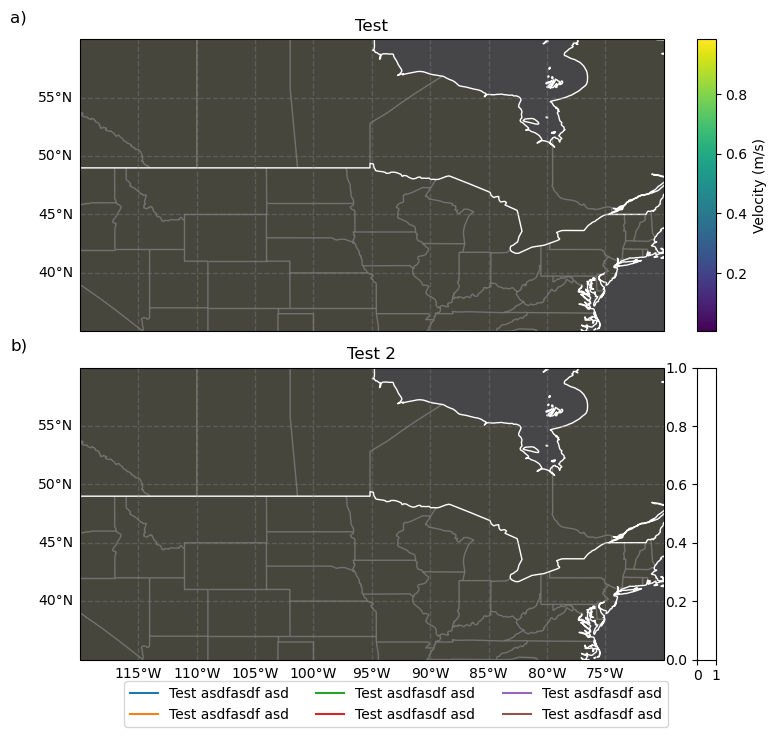

In [12]:
plt.close("all")
matplotlib.use("module://matplotlib_inline.backend_inline")
layout = visualize.horizontal.PanelledUniformMaps([-120,-70, 35, 60], subplot_width=8, rows=2, columns=1, vertical_spacing=.5, horizontal_spacing=.4)
fig, axes, colorbar_axes, legend_ax = layout.initialize_layout()
pcm = axes[0].pcolor(np.random.rand(10, 10), cmap="viridis")
lines = [axes[1].plot(np.random.rand(10)) for i in range(6)]
lines = [l[0] for l in lines]
axes[0].set_title("Test")
axes[1].set_title("Test 2")
# plt.suptitle("Test", y=.95)
plt.colorbar(pcm, cax=colorbar_axes[0], label="Velocity (m/s)")
fig.tight_layout()
legend_ax.legend(lines, ["Test asdfasdf asd"]*len(lines), loc="lower center", ncol=3)
fig.show()